In [2]:
import numpy as np
from utils.units import *
from utils.consts import *
from matplotlib import pyplot as plt

import os,sys
import csv
import re

## using diagonal region of top hat
preliminary simulations show better fall-off on the diagonal than horizontal or vertical

### 2025.03.05 - f=60 mm ideal lens, __ mm input beam dia.

In [15]:
print_data_header = True

files = ['TH_464_60mm_minus350.csv',
         'TH_464_60mm_minus300.csv',
         'TH_464_60mm_minus250.csv',
         'TH_464_60mm_minus200.csv',
         'TH_464_60mm_minus150.csv']

# get the diagonal slice for each axial plane
diag_slices = []
xy_arrays = [] # the full 2D intensity pattern
xwidths = []
ywidths = []
for file in files:
    rows = []
    with open(os.path.join('data',file)) as f: # data from Vadim
        print(f"**** processing {file}... ****")
        
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if print_data_header and i < 16: 
                print(row[0])
    
                matches = re.findall(r'X Width = ([-+]?\d*\.\d+E[-+]?\d+)|Y Height = ([-+]?\d*\.\d+E[-+]?\d+)', row[0])
                
                # Flatten the list and remove None values
                if len(matches) == 2:
                    xwidth,ywidth = [m for group in matches for m in group if m]
                    xwidths.append(float(xwidth))
                    ywidths.append(float(ywidth))
                
            else:
                try:
                    row = [float(r) for r in row if r != '']
                    rows.append(row)
                except ValueError as e:
                    # print(e)
                    # raise
                    print(row)
                    print(file)
                    pass
        xy_intensity = np.array(rows)
        xy_arrays.append(xy_intensity)
        diag_slices.append(np.diag(xy_intensity))

xy_arrays = np.array(xy_arrays)
print(xwidths)
print(ywidths)

**** processing TH_464_60mm_minus350.csv... ****
﻿Listing of POP Irradiance Data

File : C:\Users\vshofman\Documents\My ZEMAX files\TH464_BB_1529nm_2.zmx
Title: 
Date : 3/6/2025


Total Irradiance file TH464_BB_1529nm_2_0008.ZBF
Grid size (X by Y): 1024 by 1024
Point spacing (X by Y): 3.5364E-04 by 3.5364E-04 Millimeters
Beam wavelength is 1.52900 µm in the media with index 1.00000
Display X Width = 3.6213E-01, Y Height = 3.6213E-01 Millimeters

Peak Irradiance = 1.7530E+03 Watts/Millimeters^2, Total Power = 1.9242E+01 Watts
X Pilot: Size= 8.4923E-02, Waist= 8.4999E-03, Pos= -1.4757E+00, Rayleigh= 1.4845E-01

**** processing TH_464_60mm_minus300.csv... ****
﻿Listing of POP Irradiance Data

File : C:\Users\vshofman\Documents\My ZEMAX files\TH464_BB_1529nm_2.zmx
Title: 
Date : 3/6/2025


Total Irradiance file TH464_BB_1529nm_2_0009.ZBF
Grid size (X by Y): 1024 by 1024
Point spacing (X by Y): 3.4166E-04 by 3.4166E-04 Millimeters
Beam wavelength is 1.52900 µm in the media with index 1.0000

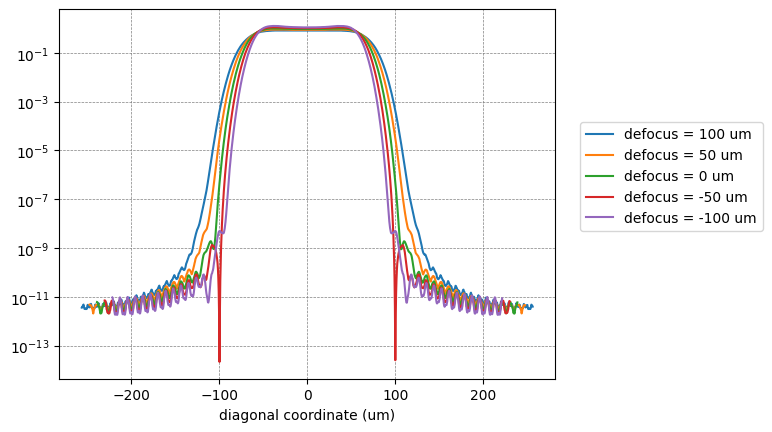

In [16]:
dz = 50

norm = np.max(diag_slices[2])

for i, sl in enumerate(diag_slices):
    diag_coords = np.linspace(0, np.sqrt(xwidths[i]**2 + ywidths[i]**2), len(sl))
    diag_coords -= np.max(diag_coords)/2
    plt.plot(1000*diag_coords, sl/norm, label=f'defocus = {(2-i)*dz:.0f} um')
plt.xlabel("diagonal coordinate (um)")
plt.yscale('log')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend(loc=(1.05, 0.4))

In [8]:
[np.max(sl) for sl in diag_slices]

[np.float64(1750.0),
 np.float64(1910.0),
 np.float64(2110.0),
 np.float64(2370.0),
 np.float64(2680.0)]

In [10]:
[np.max(sl[len(sl)//2:]) for sl in diag_slices]

[np.float64(1750.0),
 np.float64(1900.0),
 np.float64(2110.0),
 np.float64(2360.0),
 np.float64(2680.0)]

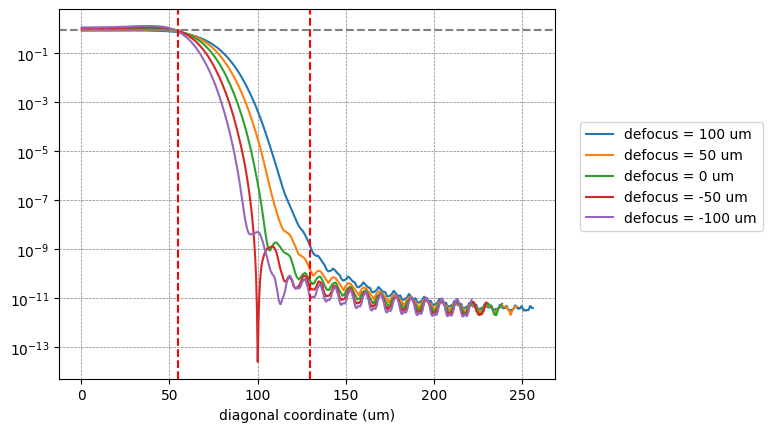

In [17]:
fig,ax = plt.subplots()

dz = 50
for i, sl in enumerate(diag_slices):
    diag_coords = np.linspace(0, np.sqrt(xwidths[i]**2 + ywidths[i]**2), len(sl))
    diag_coords -= np.max(diag_coords)/2
    
    ax.plot(1000*diag_coords[len(sl)//2:], sl[len(sl)//2:]/norm, label=f'defocus = {(2-i)*dz:.0f} um')
ax.set_xlabel("diagonal coordinate (um)")
ax.set_yscale('log')
ax.axvline(55,c='red',ls='--')
ax.axvline(55+75,c='red',ls='--')
ax.axhline(0.9,c='gray',ls='--')
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.legend(loc=(1.05, 0.4))

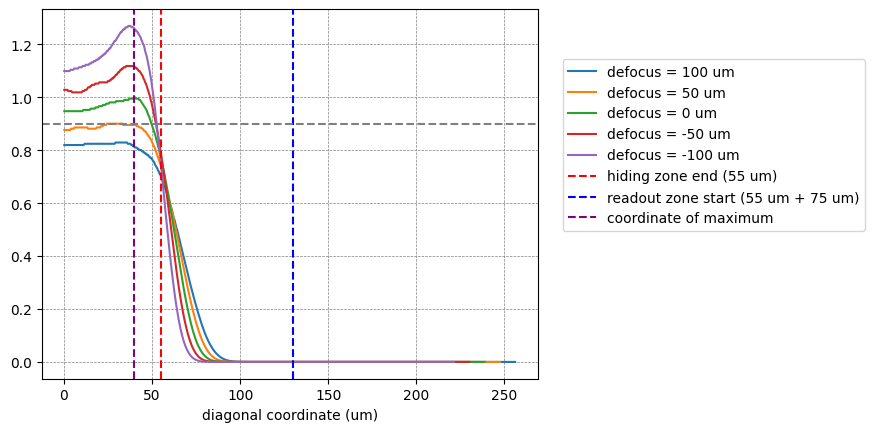

In [32]:
fig,ax = plt.subplots()

dz = 50
for i, sl in enumerate(diag_slices):
    diag_coords = np.linspace(0, np.sqrt(xwidths[i]**2 + ywidths[i]**2), len(sl))
    diag_coords -= np.max(diag_coords)/2

    if i == 2:
        focal_max_idx = np.argmax(sl[len(sl)//2:])
        x_max = 1000*diag_coords[len(sl)//2:][focal_max_idx]
    
    ax.plot(1000*diag_coords[len(sl)//2:], sl[len(sl)//2:]/norm, label=f'defocus = {(2-i)*dz:.0f} um')
ax.set_xlabel("diagonal coordinate (um)")
# ax.set_yscale('log')
ax.axvline(55,c='red',ls='--', label='hiding zone end (55 um)')
ax.axvline(55+75,c='blue',ls='--',label='readout zone start (55 um + 75 um)')
ax.axvline(x_max, label='coordinate of maximum',ls='--',c='purple')
ax.axhline(0.9,c='gray',ls='--')
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.legend(loc=(1.05, 0.4))

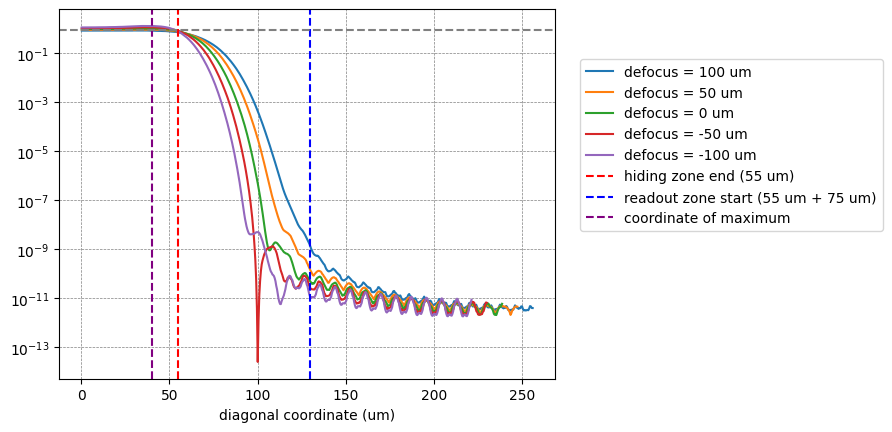

In [34]:
fig,ax = plt.subplots()

dz = 50
for i, sl in enumerate(diag_slices):
    diag_coords = np.linspace(0, np.sqrt(xwidths[i]**2 + ywidths[i]**2), len(sl))
    diag_coords -= np.max(diag_coords)/2

    if i == 2:
        focal_max_idx = np.argmax(sl[len(sl)//2:])
        x_max = 1000*diag_coords[len(sl)//2:][focal_max_idx]
    
    ax.plot(1000*diag_coords[len(sl)//2:], sl[len(sl)//2:]/norm, label=f'defocus = {(2-i)*dz:.0f} um')
ax.set_xlabel("diagonal coordinate (um)")
# ax.set_yscale('log')
ax.axvline(55,c='red',ls='--', label='hiding zone end (55 um)')
ax.axvline(55+75,c='blue',ls='--',label='readout zone start (55 um + 75 um)')
ax.axvline(x_max, label='coordinate of maximum',ls='--',c='purple')
ax.axhline(0.9,c='gray',ls='--')
ax.set_yscale('log')
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.legend(loc=(1.05, 0.4))

### 2025.03.05 - f=100 mm ideal lens, __ mm input beam dia.

Listing of POP Irradiance Data							
							
File : C:\Users\vshofman\Documents\My ZEMAX files\TH464_BB_1529nm_2.zmx							
Title: 							
Date : 3/5/2025							
							
							
Total Irradiance file TH464_BB_1529nm_2_0006.ZBF							
Grid size (X by Y): 1024 by 1024							
Point spacing (X by Y): 5.6311E-04 by 5.6311E-04 Millimeters							
Beam wavelength is 1.52900 µm in the media with index 1.00000							
Display X Width = 5.7662E-01, Y Height = 5.7662E-01 Millimeters							
							
Peak Irradiance = 7.0362E+02 Watts/Millimeters^2, Total Power = 1.9242E+01 Watts							
X Pilot: Size= 1.3531E-01, Waist= 1.4346E-02, Pos= -3.9658E+00, Rayleigh= 4.2286E-01							

In [65]:
print_data_header = True

rows = []
xwidths = []
ywidths = []
with open(os.path.join('data','DOE_TH464_nearfocus_0um.csv')) as f: # data from Vadim
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if print_data_header and i < 16: 
            print(row[0])

            matches = re.findall(r'X Width = ([-+]?\d*\.\d+E[-+]?\d+)|Y Height = ([-+]?\d*\.\d+E[-+]?\d+)', row[0])
            
            # Flatten the list and remove None values
            if len(matches) == 2:
                xwidth,ywidth = [m for group in matches for m in group if m]
                xwidths.append(float(xwidth))
                ywidths.append(float(ywidth))
            
        else:
            try:
                row = [float(r) for r in row if r != '']
                rows.append(row)
            except ValueError as e:
                print(e)
                raise

﻿Listing of POP Irradiance Data

File : C:\Users\vshofman\Documents\My ZEMAX files\TH464_BB_1529nm_2.zmx
Title: 
Date : 3/5/2025


Total Irradiance file TH464_BB_1529nm_2_0009.ZBF
Grid size (X by Y): 1024 by 1024
Point spacing (X by Y): 5.1341E-04 by 5.1341E-04 Millimeters
Beam wavelength is 1.52900 µm in the media with index 1.00000
Display X Width = 5.2573E-01, Y Height = 5.2573E-01 Millimeters

Peak Irradiance = 9.3816E+02 Watts/Millimeters^2, Total Power = 1.9242E+01 Watts
X Pilot: Size= 1.23506E-01, Waist= 1.43459E-02, Pos= -3.61585E+00, Rayleigh= 4.22864E-01



In [50]:
xy_intensity = np.array(rows)
diag_slice = np.diag(xy_intensity)

In [51]:
diag_slice.shape

(1024,)

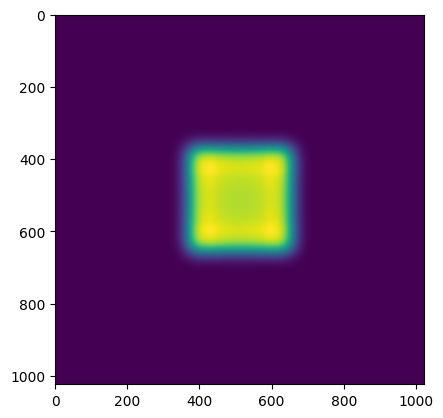

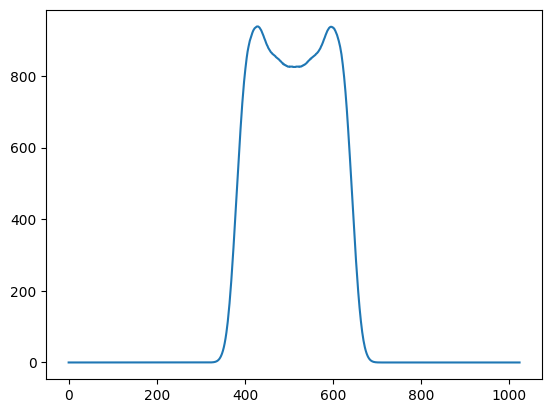

In [52]:
fig, ax = plt.subplots()
ax.imshow(xy_intensity)
plt.show()

fig, ax = plt.subplots()
ax.plot(diag_slice)

In [77]:
print_data_header = True

files = ['DOE_TH464_nearfocus_minus100um.csv',
         'DOE_TH464_nearfocus_minus50um.csv',
         'DOE_TH464_nearfocus_0um.csv',
         'DOE_TH464_nearfocus_50um.csv',
         'DOE_TH464_nearfocus_100um.csv']

# get the diagonal slice for each axial plane
diag_slices = []
xy_arrays = [] # the full 2D intensity pattern
xwidths = []
ywidths = []
for file in files:
    rows = []
    with open(os.path.join('data',file)) as f: # data from Vadim
        print(f"**** processing {file}... ****")
        
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if print_data_header and i < 16: 
                print(row[0])
    
                matches = re.findall(r'X Width = ([-+]?\d*\.\d+E[-+]?\d+)|Y Height = ([-+]?\d*\.\d+E[-+]?\d+)', row[0])
                
                # Flatten the list and remove None values
                if len(matches) == 2:
                    xwidth,ywidth = [m for group in matches for m in group if m]
                    xwidths.append(float(xwidth))
                    ywidths.append(float(ywidth))
                
            else:
                try:
                    row = [float(r) for r in row if r != '']
                    rows.append(row)
                except ValueError as e:
                    # print(e)
                    # raise
                    print(row)
                    print(file)
                    pass
        xy_intensity = np.array(rows)
        xy_arrays.append(xy_intensity)
        diag_slices.append(np.diag(xy_intensity))

xy_arrays = np.array(xy_arrays)
print(xwidths)
print(ywidths)

**** processing DOE_TH464_nearfocus_minus100um.csv... ****
﻿Listing of POP Irradiance Data

File : C:\Users\vshofman\Documents\My ZEMAX files\TH464_BB_1529nm_2.zmx
Title: 
Date : 3/5/2025


Total Irradiance file TH464_BB_1529nm_2_0007.ZBF
Grid size (X by Y): 1024 by 1024
Point spacing (X by Y): 5.3471E-04 by 5.3471E-04 Millimeters
Beam wavelength is 1.52900 µm in the media with index 1.00000
Display X Width = 5.4754E-01, Y Height = 5.4754E-01 Millimeters

Peak Irradiance = 8.2237E+02 Watts/Millimeters^2, Total Power = 1.9242E+01 Watts
X Pilot: Size= 1.2856E-01, Waist= 1.4346E-02, Pos= -3.7658E+00, Rayleigh= 4.2286E-01

**** processing DOE_TH464_nearfocus_minus50um.csv... ****
﻿Listing of POP Irradiance Data

File : C:\Users\vshofman\Documents\My ZEMAX files\TH464_BB_1529nm_2.zmx
Title: 
Date : 3/5/2025


Total Irradiance file TH464_BB_1529nm_2_0008.ZBF
Grid size (X by Y): 1024 by 1024
Point spacing (X by Y): 5.2051E-04 by 5.2051E-04 Millimeters
Beam wavelength is 1.52900 µm in the medi

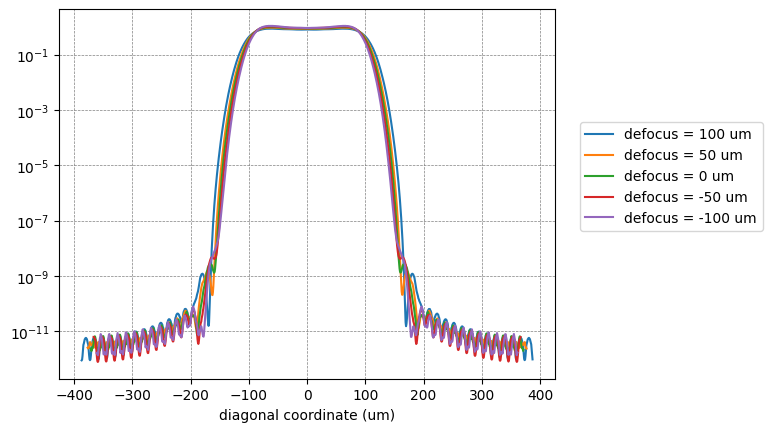

In [90]:
dz = 50

norm = np.max(diag_slices[2])

for i, sl in enumerate(diag_slices):
    diag_coords = np.linspace(0, np.sqrt(xwidths[i]**2 + ywidths[i]**2), len(sl))
    diag_coords -= np.max(diag_coords)/2
    plt.plot(1000*diag_coords, sl/norm, label=f'defocus = {(2-i)*dz:.0f} um')
plt.xlabel("diagonal coordinate (um)")
plt.yscale('log')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend(loc=(1.05, 0.4))

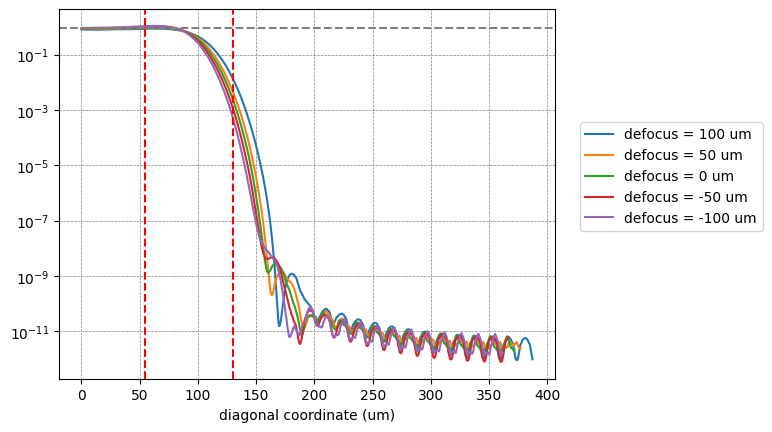

In [95]:
fig,ax = plt.subplots()

dz = 50
for i, sl in enumerate(diag_slices):
    diag_coords = np.linspace(0, np.sqrt(xwidths[i]**2 + ywidths[i]**2), len(sl))
    diag_coords -= np.max(diag_coords)/2
    
    ax.plot(1000*diag_coords[len(sl)//2:], sl[len(sl)//2:]/norm, label=f'defocus = {(2-i)*dz:.0f} um')
ax.set_xlabel("diagonal coordinate (um)")
ax.set_yscale('log')
ax.axvline(55,c='red',ls='--')
ax.axvline(55+75,c='red',ls='--')
ax.axhline(0.9,c='gray',ls='--')
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.legend(loc=(1.05, 0.4))

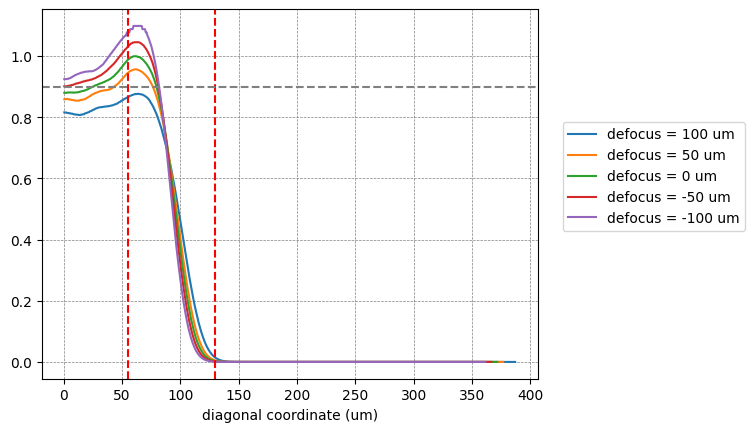

In [96]:
fig,ax = plt.subplots()

dz = 50
for i, sl in enumerate(diag_slices):
    diag_coords = np.linspace(0, np.sqrt(xwidths[i]**2 + ywidths[i]**2), len(sl))
    diag_coords -= np.max(diag_coords)/2
    
    ax.plot(1000*diag_coords[len(sl)//2:], sl[len(sl)//2:]/norm, label=f'defocus = {(2-i)*dz:.0f} um')
ax.set_xlabel("diagonal coordinate (um)")
# ax.set_yscale('log')
ax.axvline(55,c='red',ls='--')
ax.axvline(55+75,c='red',ls='--')
ax.axhline(0.9,c='gray',ls='--')
ax.grid(True, color='gray', linestyle='--', linewidth=0.5)
ax.legend(loc=(1.05, 0.4))

## preliminary data from Vadim - old

In [55]:
rows = []
with open(os.path.join('data','HoloOr_464_3mm_waist.csv')) as f: # data from Vadim
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i == 5: 
            print(row)
        try:
            row = [float(r) for r in row if r != '']
            rows.append(row)
        except ValueError:
            pass

['-0.37361590', '0.00000297', '', '-0.35914700', '0.00000252', '', '-0.34467810', '0.00000337', '', '-0.33020920', '0.00000279', '', '-0.31574030', '0.00000373', '', '-0.30127140', '0.00000288', '', '-0.28680250', '0.00000431', '', '-0.27233360', '0.00000296', '', '-0.25786470', '0.00000522', '', '-0.24339580', '0.00000251', '', '-0.22892690', '0.00000703', '', '-0.21445800', '0.00000203', '', '-0.19998900', '0.00001014', '', '-0.18552010', '0.00000208']


In [56]:
cols_temp = np.array(rows).transpose()
cols = []
for col in cols_temp:
    if col[0] != '':
        cols.append(col)

# each row is a different axial plane
x_coords = []
intensities = []

for i, col in enumerate(cols):
    if i % 2:
        intensities.append(col)
    else:
        x_coords.append(col)

intensities = np.array(intensities)
x_coords = np.array(x_coords)

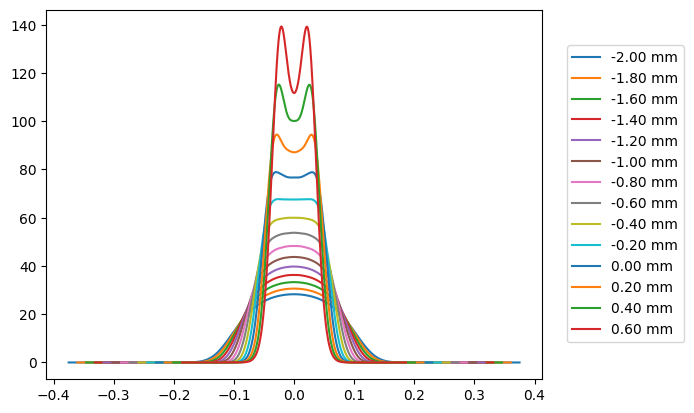

In [57]:
fig, ax = plt.subplots()
dz = 0.2
z0 = -2
for iz in range(intensities.shape[0]):
   ax.plot(x_coords[iz], intensities[iz], label=f'{z0 + dz*iz:.2f} mm')
ax.legend(loc=(1.05,0.1))

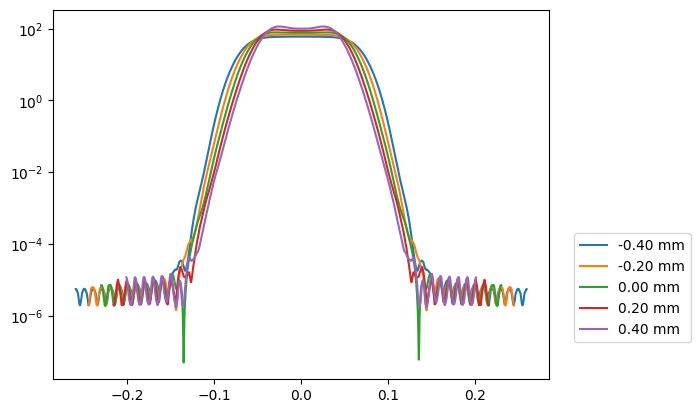

In [58]:
fig, ax = plt.subplots()
dz = 0.2
z0 = -2
zmin = -0.5
zmax = -zmin
for iz in range(intensities.shape[0]):
    z = z0 + dz*iz
    if zmin < z < zmax:
        ax.plot(x_coords[iz], intensities[iz], label=f'{z:.2f} mm')
ax.set_yscale('log')
ax.legend(loc=(1.05,0.1))

In [59]:
intensities[0].shape

(2047,)